In [1]:
!pip install --upgrade --no-dependencies llm_bhasa

# LLM Training

## Training - Direct through library

In [2]:
from llm_bhasa.harmony import training
training.train?

Model cannot be loaded as model_and_optimizer.pth doesnt exist
Device: cuda
##============== Model Summary =========================##
# Total number of parameters: 163,009,536
# Token embedding layer shape: torch.Size([50257, 768])
# Output layer shape: torch.Size([50257, 768])
# Number of trainable parameters considering weight tying: 124,412,160
# Total size of the model: 621.83 MB
##======================================================##


Total filepaths: len['the-verdict.txt', 'gutenberg_books/1342.txt', 'gutenberg_books/84.txt', 'gutenberg_books/1661.txt']
Ep 1 (Step 000000): Train loss 11.946, Val loss 11.964
Every effort moves you, and                                                
Ep 2 (Step 000100): Train loss 7.194, Val loss 8.380
Every effort moves you, and I am    ” ” ” ” ” ” ” ” ” ” ” ” ” ” 
Ep 3 (Step 000200): Train loss 6.590, Val loss 8.195
Every effort moves you, and                                                
Ep 4 (Step 000300): Train loss 6.071, Val loss 8.021
Every effort moves you, and I am sure, and I am sure, and I am not                                   
Ep 5 (Step 000400): Train loss 5.487, Val loss 7.952
Every effort moves you, and I was a    ” “I have ” ” ” ” ” ” ” ” ” ” ” 
Ep 6 (Step 000500): Train loss 4.993, Val loss 7.984
Every effort moves you  ” “I have been ” ” ” ” ” ” ” ” ” ” ” ” ” 
Ep 7 (Step 000600): Train loss 4.252, Val loss 7.967
Every effort moves you   ” “I have you.” “I am n

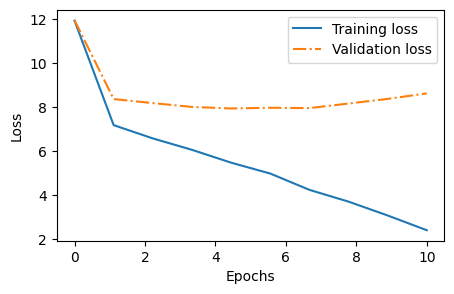

In [3]:
%%time

from llm_bhasa.harmony import training
training.train(num_epochs=10, eval_freq=100)  # Print eval every 100 steps

## Training - Lets break down

Below we will break above single line function into building blocks to have more fine grain control

In [4]:
import os
import torch
import torch.nn as nn
from llm_bhasa.harmony import config
from llm_bhasa.harmony import model
from llm_bhasa.harmony import training
from llm_bhasa.harmony import data, dataset

### Download data

In [5]:
gutenberg_book_ids = range(50000)

In [6]:
bookkeep_file = "/kaggle/input/download-gutenberg-book-dataset/guthenberg_bookkeeper.csv"
import pandas as pd

if os.path.exists(bookkeep_file):
    df_bookkeep = pd.read_csv(bookkeep_file)
    df_bookkeep = df_bookkeep[df_bookkeep['status'] == True]
    gutenberg_book_ids = df_bookkeep['book_id'].tolist()

print(f"Total book_ids: {len(gutenberg_book_ids)}")

Total book_ids: 47719


In [7]:
# #comment/uncomment to download gutenberg directly from websites
# filepaths = data.download_sample_text(gutenberg_book_ids=gutenberg_book_ids, verbose=False, njobs=4)
# print(f"Total Downloaded Books: {len(filepaths)}")

In [8]:
# #comment/uncomment to generate URI, which will be downloaded later
base_url = "https://www.gutenberg.org/files/{}/{}-0.txt"
fileurls = [base_url.format(book_id, book_id) for book_id in gutenberg_book_ids]
print(f"Total Downloaded Books: {len(fileurls)}")

Total Downloaded Books: 47719


In [9]:
train_data, val_data = training.split_data(fileurls[0:100], train_ratio=0.90) # Limit number of files

### Data Loaders

In [10]:
model_filepath = "/kaggle/working/model_and_optimizer.pth"
config_train = config.GPT_CONFIG_124M
context_len = config_train['context_length']

In [11]:
# Creating data loader for both train and validation
train_loader = dataset.create_dataloader(train_data, batch_size=2, max_length=context_len, stride=context_len,
                                         drop_last=True, num_workers=0)

val_loader = dataset.create_dataloader(val_data, batch_size=2, max_length=context_len, stride=context_len,
                                        drop_last=False, num_workers=0)

## Since number of files which wikll be downloaded will be huge, this step can be skipped
# for cntr, data in enumerate(train_loader):
#     pass
# print(f"Total batches: {cntr}")

### Model Defination

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
config_train

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

define our model based on passed configuration, different configuration can also be passed

In [14]:
model_llm = model.LLMModel(config_train)

In [15]:
# !rm -rf ~/.cache/huggingface/hub  -- delete any cache

### Loading Previously trained model from HuggingFace
we dont want to train from scratch, lets load previously trained model of same config from huggingface 
<br/>

<b>repo</b> - https://huggingface.co/pankajr141/llm_bhasa_v1

In [16]:
repo = "pankajr141"
modelname = "llm_bhasa_v1"

repo_url = f"{repo}/{modelname}"
repo_url

'pankajr141/llm_bhasa_v1'

In [17]:
# Load from hugging face
model_llm = model.LLMModel.from_pretrained(repo_url)

config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/702M [00:00<?, ?B/s]

In [18]:
# model_llm = model.load_model(model_llm, model_filepath) # Resuming training by loading previously trained model
model.print_model_information(model_llm)

if torch.cuda.device_count() > 1:
    model_llm = nn.DataParallel(model_llm)

model_llm.to(device)                                    # Assigning GPU/CPU to model
print("Model Defined")

##============== Model Summary =========================##
# Total number of parameters: 163,009,536
# Token embedding layer shape: torch.Size([50257, 768])
# Output layer shape: torch.Size([50257, 768])
# Number of trainable parameters considering weight tying: 124,412,160
# Total size of the model: 621.83 MB
##======================================================##
Model Defined


### Additional Defination

In [19]:
optimizer = torch.optim.AdamW(model_llm.parameters(), lr=0.0004, weight_decay=0.1)

In [20]:
from llm_bhasa.harmony import tokenizer as tokenizer_lib
tokenizer = tokenizer_lib.get_tokenizer()
tokenizer

<Encoding 'gpt2'>

### Lets train

In [21]:
%%time

num_epochs = 1
# Training LLM model from scratch
train_losses, val_losses, tokens_seen = training.train_model(model_llm, 
                                                             train_loader,
                                                             val_loader, 
                                                             optimizer, 
                                                             device,
                                                             num_epochs=num_epochs,
                                                             eval_freq=500,   # Loss will be printed every 500 steps
                                                             eval_iter=50,    # Number of batches to use for each evaluation
                                                             start_context="Every effort moves you", 
                                                             tokenizer=tokenizer)
model.save_model(model_llm, optimizer, model_filepath)

Ep 1 (Step 000000): Train loss 6.744, Val loss 6.971
Ep 1 (Step 000500): Train loss 4.998, Val loss 6.816
Ep 1 (Step 001000): Train loss 6.226, Val loss 6.796
Ep 1 (Step 001500): Train loss 5.280, Val loss 6.171
Ep 1 (Step 002000): Train loss 5.077, Val loss 5.671
Ep 1 (Step 002500): Train loss 4.978, Val loss 6.469
Ep 1 (Step 003000): Train loss 5.069, Val loss 5.662
Ep 1 (Step 003500): Train loss 5.235, Val loss 5.588
Ep 1 (Step 004000): Train loss 5.207, Val loss 5.643
Ep 1 (Step 004500): Train loss 5.192, Val loss 5.552
Ep 1 (Step 005000): Train loss 5.237, Val loss 5.472
Ep 1 (Step 005500): Train loss 5.288, Val loss 5.707
Ep 1 (Step 006000): Train loss 5.448, Val loss 5.868
Ep 1 (Step 006500): Train loss 5.443, Val loss 5.512
Ep 1 (Step 007000): Train loss 5.363, Val loss 5.340
Ep 1 (Step 007500): Train loss 8.144, Val loss 8.291
                                               
Model saved to /kaggle/working/model_and_optimizer.pth
CPU times: user 43min 43s, sys: 9min 47s, total: 

In [22]:
# model_llm.to(device)
# training.evaluate_model(model_llm, train_loader, val_loader, device, 50)

### Plot Results Train vs Validation

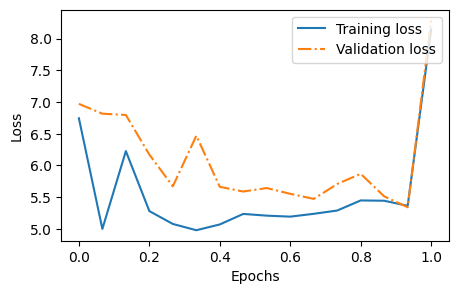

In [23]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
training.plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Generate some samples

In [24]:
from llm_bhasa.harmony import generator

model_llm.eval()  # Disable dropout during evaluation
model_llm.to(device)

context_len = config_train['context_length']

In [25]:
def generate_text(start_context):
    tokenizer = tokenizer_lib.get_tokenizer()
    encoded = tokenizer_lib.text_to_token_ids(start_context, tokenizer).to(device)
    token_ids  = generator.generate(model=model_llm, idx=encoded, max_new_tokens=50, context_size=context_len)
    decoded_text = tokenizer_lib.token_ids_to_text(token_ids, tokenizer)
    return decoded_text.replace("\n", " ")

In [26]:
generate_text("Hello, I am")

'Hello, I am\r                                                 '

In [27]:
generate_text("Lets start")

'Lets start of the\r                                               '

In [28]:
generate_text("How is your")

'How is your\r                                                 '

## Deploy to Huggingface

In [29]:
# from huggingface_hub import notebook_login
# notebook_login()

In [30]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
huggingfacetoken = user_secrets.get_secret("huggingface")

from huggingface_hub.hf_api import HfFolder
HfFolder.save_token(huggingfacetoken)

Depending on whether multiple GPU are availaible model_llm can be instance of DataParallel which can cause issue while saving and loading model, hence sorting the issue.

In [31]:
from torch.nn.parallel.data_parallel import DataParallel
if isinstance(model_llm, DataParallel):
    print("model is instance of DataParallel, changing the class")
    model_llm = model_llm.module

In [32]:
# save locally
model_llm.save_pretrained(modelname)

# push to the hub
model_llm.push_to_hub(repo_url)

# Load from hugging face
# model_llm = model.LLMModel.from_pretrained(repo_url)

model.safetensors:   0%|          | 0.00/702M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pankajr141/llm_bhasa_v1/commit/b740a07e950b7b09a4563663507e0ce44d92b150', commit_message='Push model using huggingface_hub.', commit_description='', oid='b740a07e950b7b09a4563663507e0ce44d92b150', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pankajr141/llm_bhasa_v1', endpoint='https://huggingface.co', repo_type='model', repo_id='pankajr141/llm_bhasa_v1'), pr_revision=None, pr_num=None)